In [104]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import math 
import sympy as sp
from scipy.optimize import fsolve
from scipy.integrate import quad
import time

In [105]:
import gammapy
from IPython.display import display
# Gammapy - Datos y Observaciones
from gammapy.data import FixedPointingInfo, Observation, observatory_locations
from gammapy.datasets import MapDataset
from gammapy.irf import load_irf_dict_from_file
from gammapy.makers import (
    MapDatasetMaker,
    SafeMaskMaker,
    ReflectedRegionsBackgroundMaker,
    FoVBackgroundMaker,
)
from gammapy.maps import MapAxis, WcsGeom, WcsNDMap
from gammapy.modeling import Fit, Parameter
from gammapy.modeling.models import (
    FoVBackgroundModel,
    GaussianSpatialModel,
    Models,
    PowerLawSpectralModel,
    SkyModel,
    PointSpatialModel,
    SpatialModel,
    SpectralModel,
    TemplateSpatialModel,
)
from gammapy.astro.darkmatter import (
    DarkMatterAnnihilationSpectralModel,
    DarkMatterDecaySpectralModel,
    JFactory,
    PrimaryFlux,
    profiles,
    NFWProfile,
)
from gammapy.astro.darkmatter.profiles import EinastoProfile
from gammapy.astro.darkmatter.spectra import DarkMatterAnnihilationSpectralModel

# IRFs
from gammapy.irf import (
    IRF,
    Background3D,
    EffectiveAreaTable2D,
    EnergyDependentMultiGaussPSF,
    EnergyDispersion2D,
)
from gammapy.irf.io import COMMON_IRF_HEADERS, IRF_DL3_HDU_SPECIFICATION

# Mapas y herramientas de IRFs
from gammapy.makers.utils import (
    make_edisp_kernel_map,
    make_map_exposure_true_energy,
    make_psf_map,
)

# Astronomía y coordenadas
import numpy as np
import astropy.units as u
from astropy.visualization import quantity_support
from astropy import constants as const
from astropy.coordinates import SkyCoord, EarthLocation, AltAz, angular_separation
from astropy.time import Time

# Regiones
from regions import CircleSkyRegion, RectangleSkyRegion


rho_s = 4.935e-01 GeV / cm3


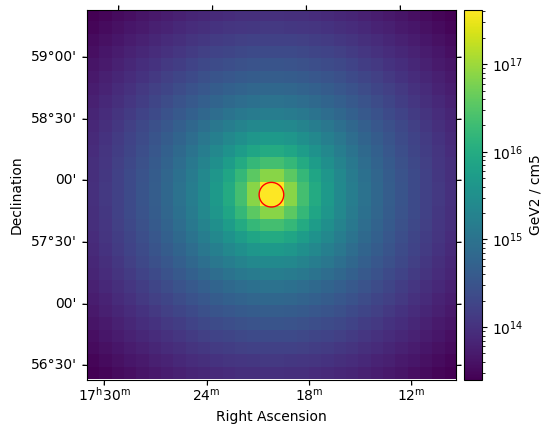

J-factor integrado en un círculo de 0.1° alrededor de Draco: 1.66e+18 GeV2 / cm5
18.220880457926672


In [106]:
#J_factor para la galaxia esferoidal enana Draco 

# 1) Definir la posición de la dSph :
position_dwarf_draco = SkyCoord(260.05, 57.915, frame="icrs", unit="deg")

# 2) Definir la distancia (aprox. 81 kpc para Draco)
distance_dwarf_draco = 76 * u.kpc

# 3) Elegir el perfil de densidad. 
rho_s_msun_kpc3 = 1.3e7 * (u.M_sun / u.kpc**3)  

# Convertir de M_sun/kpc³ a GeV/cm³ usando astropy
rho_s_GeV_cm3 = rho_s_msun_kpc3.to(u.GeV / u.cm**3, equivalencies=u.mass_energy())

print(f"rho_s = {rho_s_GeV_cm3:.3e}")

draco_profile = profiles.EinastoProfile(
    r_s=0.91 * u.kpc,       
    rho_s=rho_s_GeV_cm3
)

# 4) ¿Escalar a la densidad local? No

# 5) Crear la geometría del mapa. 
geom_draco = WcsGeom.create(
    binsz=0.1,
    skydir=position_dwarf_draco,
    width=3.0,          
    frame="icrs"
)

# 6) Crear la fábrica de J-Factor para la galaxia enana
#    Nota: en lugar de "profiles.DMProfile.DISTANCE_GC", pasamos 'distance_dwarf'
jfactory = JFactory(
    geom=geom_draco,
    profile=draco_profile,
    distance=distance_dwarf_draco
)

# 7) Calcular el mapa de J-Factor (por defecto, para aniquilación)
jfact_draco = jfactory.compute_jfactor()

# 8) Construir el mapa WcsNDMap para poderlo plotear
jfact_map_draco = WcsNDMap(geom=geom_draco, data=jfact_draco.value, unit=jfact_draco.unit)

plt.figure()
ax = jfact_map_draco.plot(cmap="viridis", norm=LogNorm(), add_cbar=True)

# 9) Definir alguna región de interés, por ejemplo un círculo de 0.5° alrededor de Draco
sky_reg = CircleSkyRegion(center=position_dwarf_draco, radius=0.1 * u.deg)
pix_reg = sky_reg.to_pixel(wcs=geom_draco.wcs)
pix_reg.plot(ax=ax, facecolor="none", edgecolor="red", label="0.1 deg circle")
plt.savefig('jfactor_draco')
plt.show()

# 10) Integrar el valor de J-Factor dentro de dicha región
total_jfact = pix_reg.to_mask().multiply(jfact_draco).sum()
print(f"J-factor integrado en un círculo de 0.1° alrededor de Draco: {total_jfact:.3g}")
logtotal_jfact= np.log10(total_jfact.value)
print(logtotal_jfact)

rho_s = 6.454e-01 GeV / cm3


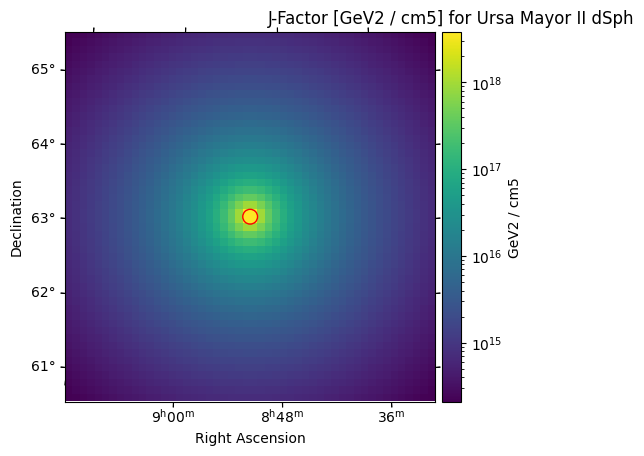

J-factor integrado en un círculo de 0.1° alrededor de Ursa Mayor II: 1.52e+19 GeV2 / cm5
19.182115481874284


In [107]:
#J_factor para la galaxia esferoidal enana Ursa Mayor II 

# 1) Definir la posición de la dSph :
position_dwarf_ursa = SkyCoord(132.87, 63.13, frame="icrs", unit="deg")

# 2) Definir la distancia 
distance_dwarf_ursa = 32 * u.kpc

# 3) Elegir el perfil de densidad. 

rho_s_msun_kpc3 = 1.7e7 * (u.M_sun / u.kpc**3)  

# Convertir de M_sun/kpc³ a GeV/cm³ usando astropy
rho_s_GeV_cm3 = rho_s_msun_kpc3.to(u.GeV / u.cm**3, equivalencies=u.mass_energy())

print(f"rho_s = {rho_s_GeV_cm3:.3e}")

ursa_profile = profiles.EinastoProfile(
    r_s=0.96 * u.kpc,       
    rho_s=rho_s_GeV_cm3
)

# 5) Crear la geometría del mapa. 
geom_ursa = WcsGeom.create(
    binsz=0.1,
    skydir=position_dwarf_ursa,
    width=5.0,           
    frame="icrs"
)

# 6) Crear la fábrica de J-Factor para la galaxia enana
jfactory = JFactory(
    geom=geom_ursa,
    profile=ursa_profile,
    distance=distance_dwarf_ursa
)

# 7) Calcular el mapa de J-Factor 
jfact_ursa = jfactory.compute_jfactor()

# 8) Construir el mapa WcsNDMap para poderlo plotear
jfact_map_ursa = WcsNDMap(geom=geom_ursa, data=jfact_ursa.value, unit=jfact_ursa.unit)

plt.figure()
ax = jfact_map_ursa.plot(cmap="viridis", norm=LogNorm(), add_cbar=True)
plt.title(f"J-Factor [{jfact_map_ursa.unit}] for Ursa Mayor II dSph")

# 9) Definir alguna región de interés
sky_reg = CircleSkyRegion(center=position_dwarf_ursa, radius=0.1 * u.deg)
pix_reg = sky_reg.to_pixel(wcs=geom_ursa.wcs)
pix_reg.plot(ax=ax, facecolor="none", edgecolor="red", label="0.1 deg circle")

plt.show()

# 10) Integrar el valor de J-Factor dentro de dicha región
total_jfact = pix_reg.to_mask().multiply(jfact_ursa).sum()
print(f"J-factor integrado en un círculo de 0.1° alrededor de Ursa Mayor II: {total_jfact:.3g}")
logtotal_jfact= np.log10(total_jfact.value)
print(logtotal_jfact)

rho_s = 8.732e+00 GeV / cm3


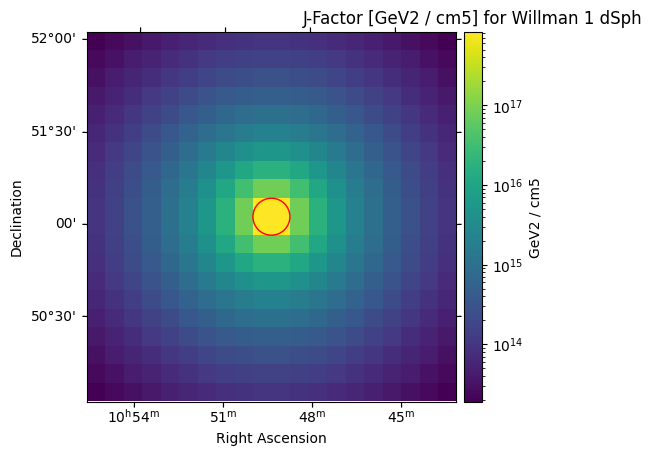

J-factor integrado en un círculo de 0.1° alrededor de Willman 1: 3.35e+18 GeV2 / cm5
18.524765971276672


In [108]:
#J_factor para la galaxia esferoidal enana william

# 1) Definir la posición de la dSph :
position_dwarf_william = SkyCoord(162.34, 51.05, frame="icrs", unit="deg")

# 2) Definir la distancia 
distance_dwarf_william = 38 * u.kpc

# 3) Elegir el perfil de densidad. 

rho_s_msun_kpc3 = 23e7 * (u.M_sun / u.kpc**3)  

# Convertir de M_sun/kpc³ a GeV/cm³ usando astropy
rho_s_GeV_cm3 = rho_s_msun_kpc3.to(u.GeV / u.cm**3, equivalencies=u.mass_energy())

print(f"rho_s = {rho_s_GeV_cm3:.3e}")

william_profile = profiles.EinastoProfile(
    r_s=0.12 * u.kpc,       
    rho_s=rho_s_GeV_cm3
)

# 5) Crear la geometría del mapa. 
geom_william = WcsGeom.create(
    binsz=0.1,
    skydir=position_dwarf_william,
    width=2.0,           # Tamaño de la región (en grados)
    frame="icrs"
)

# 6) Crear la fábrica de J-Factor para la galaxia enana
jfactory = JFactory(
    geom=geom_william,
    profile=william_profile,
    distance=distance_dwarf_william
)

# 7) Calcular el mapa de J-Factor 
jfact_william = jfactory.compute_jfactor()

# 8) Construir el mapa WcsNDMap para poderlo plotear
jfact_map_william = WcsNDMap(geom=geom_william, data=jfact_william.value, unit=jfact_william.unit)

plt.figure()
ax = jfact_map_william.plot(cmap="viridis", norm=LogNorm(), add_cbar=True)
plt.title(f"J-Factor [{jfact_map_william.unit}] for Willman 1 dSph")

# 9) Definir alguna región de interés
sky_reg = CircleSkyRegion(center=position_dwarf_william, radius=0.1 * u.deg)
pix_reg = sky_reg.to_pixel(wcs=geom_william.wcs)
pix_reg.plot(ax=ax, facecolor="none", edgecolor="red", label="0.1 deg circle")

plt.show()

# 10) Integrar el valor de J-Factor dentro de dicha región
total_jfact = pix_reg.to_mask().multiply(jfact_william).sum()
print(f"J-factor integrado en un círculo de 0.1° alrededor de Willman 1: {total_jfact:.3g}")
logtotal_jfact= np.log10(total_jfact.value)
print(logtotal_jfact)

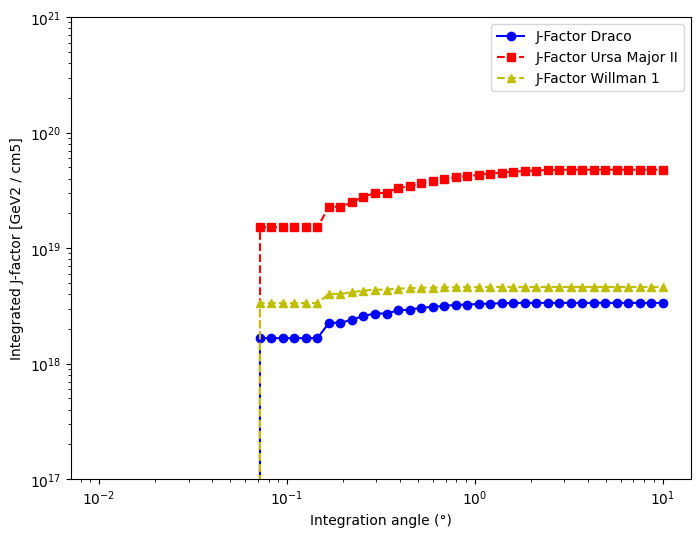

In [109]:
# Definir el rango de ángulos de integración (de 0.01° a 10° en escala logarítmica)
angles = np.logspace(-2, 1, 50) * u.deg  


jfactor_draco_integrated = []
jfactor_ursa_integrated = []
jfactor_william_integrated = []

for theta in angles:
    # ---- Para Draco ----
    sky_reg_draco = CircleSkyRegion(center=position_dwarf_draco, radius=theta)
    pix_reg_draco = sky_reg_draco.to_pixel(wcs=geom_draco.wcs)
    total_jfact_draco = pix_reg_draco.to_mask().multiply(jfact_draco).sum().value  # Extraer el valor sin unidades
    jfactor_draco_integrated.append(total_jfact_draco)

    # ---- Para Ursa Mayor II ----
    sky_reg_ursa = CircleSkyRegion(center=position_dwarf_ursa, radius=theta)
    pix_reg_ursa = sky_reg_ursa.to_pixel(wcs=geom_ursa.wcs)
    total_jfact_ursa = pix_reg_ursa.to_mask().multiply(jfact_ursa).sum().value  # Extraer el valor sin unidades
    jfactor_ursa_integrated.append(total_jfact_ursa)
    # ---- Para Willman 1 ----
    sky_reg_william = CircleSkyRegion(center=position_dwarf_william, radius=theta)
    pix_reg_william = sky_reg_william.to_pixel(wcs=geom_william.wcs)
    total_jfact_william = pix_reg_william.to_mask().multiply(jfact_william).sum().value  # Extraer el valor sin unidades
    jfactor_william_integrated.append(total_jfact_william)


jfactor_draco_integrated = np.array(jfactor_draco_integrated)
jfactor_ursa_integrated = np.array(jfactor_ursa_integrated)
jfactor_william_integrated = np.array(jfactor_william_integrated)

plt.figure(figsize=(8, 6))
plt.plot(angles, jfactor_draco_integrated, marker="o", linestyle="-", color="b", label="J-Factor Draco")
plt.plot(angles, jfactor_ursa_integrated, marker="s", linestyle="--", color="r", label="J-Factor Ursa Major II")
plt.plot(angles, jfactor_william_integrated, marker="^", linestyle="--", color="y", label="J-Factor Willman 1")

plt.xscale("log")
plt.yscale("log")
plt.ylim([1e17, 1e21])

plt.xlabel("Integration angle (°)")
plt.ylabel(f"Integrated J-factor [{jfact_draco.unit}]")

plt.legend()
plt.savefig('jfactor_variation')
plt.show()


In [110]:
import os

os.environ["GAMMAPY_DATA"] = r"C:\Users\pauli\GAMMAPY-DATA"

import pathlib
dm_path = pathlib.Path(os.environ["GAMMAPY_DATA"]) / "dark_matter_spectra" / "AtProduction_gammas.dat"
print("Full DM file path =", dm_path)
print("File exists?       =", dm_path.exists())


Full DM file path = C:\Users\pauli\GAMMAPY-DATA\dark_matter_spectra\AtProduction_gammas.dat
File exists?       = True


C:\Users\pauli\AppData\Local\Programs\Python\Python313\Lib\site-packages\gammapy\modeling\models\spectral.py:482: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  ax.plot(energy.center, flux.quantity[:, 0, 0], **kwargs)
C:\Users\pauli\AppData\Local\Programs\Python\Python313\Lib\site-packages\gammapy\modeling\models\spectral.py:482: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  ax.plot(energy.center, flux.quantity[:, 0, 0], **kwargs)
C:\Users\pauli\AppData\Local\Programs\Python\Python313\Lib\site-packages\gammapy\modeling\models\spectral.py:482: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  ax.plot(energy.center, flux.quantity[:, 0, 0], **kwargs)
C:\Users\pauli\AppData\Local\Programs\Python\Python313\Lib\site-packages\gammapy\modeling\models\spectral.py:482: UserWarning: This axis already has a converter

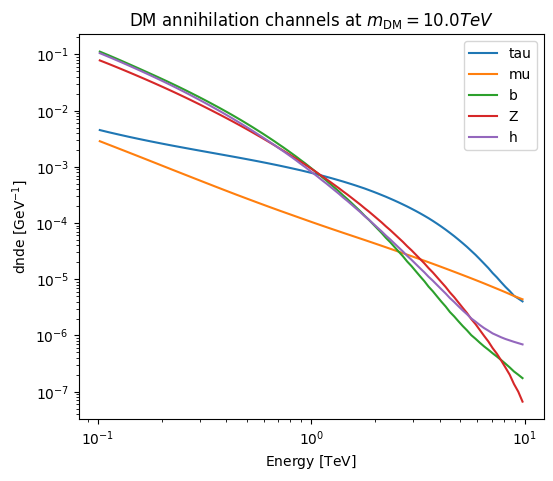

In [111]:

# Definir la masa de DM:
mDM = 10.0 * u.TeV

# Definir los canales de interés (incluyendo 'h' para Higgs):
channels = ["tau", "mu", "b", "Z", "h"]

plt.figure(figsize=(6, 5))


plt.yscale("log")
plt.xlabel("Energy [TeV]")
plt.ylabel(r"dN/dE [1/GeV]")


for channel in channels:
    fluxes = PrimaryFlux(mDM=mDM, channel=channel)
    fluxes.plot(
        energy_bounds=[mDM / 100, mDM],  # rango de energía desde 0.01 TeV hasta 1 TeV
        label=channel,
        yunits=u.Unit("1/GeV"),
    )

plt.title(rf"DM annihilation channels at $m_{{\mathrm{{DM}}}} = {mDM:.1f}$")
plt.legend()
plt.show()

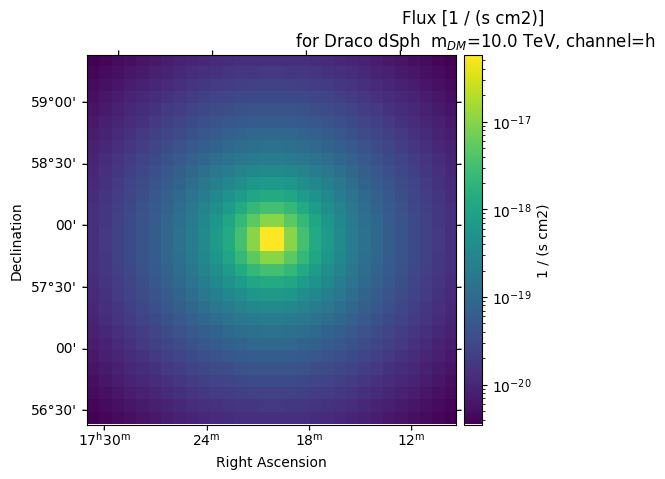

In [112]:
channel = "h"
massDM = 10 * u.TeV
diff_flux = DarkMatterAnnihilationSpectralModel(mass=massDM, channel=channel)
int_flux = (
    jfact_draco * diff_flux.integral(energy_min=0.1 * u.TeV, energy_max=10 * u.TeV).sum(axis=0)
).to("cm-2 s-1")

flux_map = WcsNDMap(geom=geom_draco, data=int_flux.value, unit="cm-2 s-1")

plt.figure()
ax = flux_map.plot(cmap="viridis", norm=LogNorm(), add_cbar=True)
plt.title(
    f"Flux [{int_flux.unit}]\n for Draco dSph  m$_{{DM}}$={fluxes.mDM.to('TeV')}, channel={fluxes.channel}"
)

plt.show()


In [113]:
#necesito calcular el ángulo cenital de Draco para saber que irfs utilizar porque me salta un mensaje de que mis coordenadas de la fuente están fuera
#del rango del mapa valido de la IRF.

# 1) Coordenadas de Draco
draco = SkyCoord(ra=260.05167 * u.deg, dec=57.915 * u.deg, frame="icrs")
# Convertir a formato hh mm ss ±dd mm ss
draco_formatted = draco.to_string('hmsdms')
print(draco_formatted)

# 2) Ubicación del CTA Norte
cta_norte = EarthLocation(lat=28.762 * u.deg, lon=-17.89 * u.deg, height=2200 * u.m)  

# 3) Momento de la observación 
time = Time("2025-06-17 01:00:00")  # UTC
#mirar cuando draco es visible desde el hemisferio norte. Mirar cual es la altura de Draco cuando culmina, cuanto más te acercas al horizonte menos sensible eres a las bajas energías. 
# 4) Convertir Draco a coordenadas altazimutales
altaz = AltAz(obstime=time, location=cta_norte)
draco_altaz = draco.transform_to(altaz)

# 5) Obtener la altitud y calcular el ángulo cenital
altitud = draco_altaz.alt.deg  # Altitud en grados
zenith_angle = 90 - altitud  # Ángulo cenital

print(f"Altitud de Draco: {altitud:.2f}°")
print(f"Ángulo cenital: {zenith_angle:.2f}°")


17h20m12.4008s +57d54m54s
Altitud de Draco: 60.82°
Ángulo cenital: 29.18°


C:\Users\pauli\AppData\Local\Programs\Python\Python313\Lib\site-packages\gammapy\data\observations.py:294: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


Eventos antes de fake: 0
Eventos después de fake: 27081119.0


interactive(children=(SelectionSlider(continuous_update=False, description='Select energy:', layout=Layout(wid…

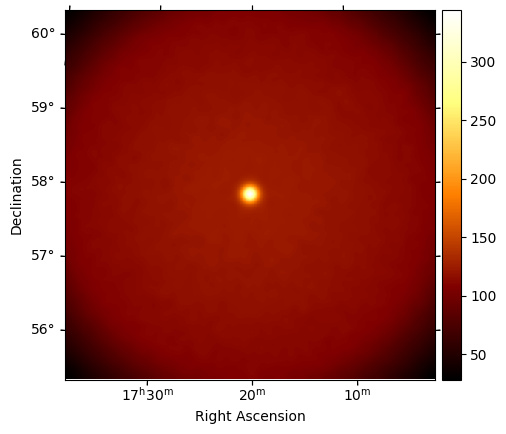

In [114]:
#Simulación de observación de Draco
# Parámetros de aniquilación de materia oscura
channel = "h"
massDM = 10 * u.TeV

# 1) Definir la posición y distancia de Draco
draco_pos = SkyCoord(260.05, 57.915, frame="icrs", unit="deg")
draco_dist = 76 * u.kpc

# 2) Elegir el perfil de densidad (NFW o Einasto)
rho_s_msun_kpc3 = 1.3e7 * (u.M_sun / u.kpc**3)  
# Convertir de M_sun/kpc³ a GeV/cm³ usando astropy
rho_s_GeV_cm3 = rho_s_msun_kpc3.to(u.GeV / u.cm**3, equivalencies=u.mass_energy())
jfact_draco = 1.66e23 * u.GeV**2 / u.cm**5 #hay que aumentar 5 ordenes de magnitud el factor astrofísico para que empezemos a tener una señal.
draco_profile = EinastoProfile(
    r_s=0.91 * u.kpc,       
    rho_s=rho_s_GeV_cm3
)

# 3) Definir las mallas de energía con el mismo número de bins
energy_edges = np.logspace(-1, 2, 15)  # Esto crea un eje de energía en el rango de 10 TeV a 100 TeV con 30 bins.
energy_reco = MapAxis.from_edges(energy_edges, unit="TeV", name="energy", interp="log")
energy_true = MapAxis.from_edges(energy_edges, unit="TeV", name="energy_true", interp="log")

# 4) Crear la geometría del mapa
position_dwarf_draco = draco_pos
geom_draco = WcsGeom.create(
    skydir=position_dwarf_draco,
    binsz=0.01,
    width=5.0,
    frame="icrs",
    axes=[energy_reco]  
)

# 5) Crear modelo espacial puntual
spatial_model = PointSpatialModel(
    lon_0=draco_pos.ra,
    lat_0=draco_pos.dec,
    frame="icrs"
)

# 6) Crear modelo espectral de aniquilación de materia oscura
spectral_model = DarkMatterAnnihilationSpectralModel(
    mass=massDM, channel=channel, jfactor=jfact_draco)

# 7) Crear el modelo combinado para Draco
model_simu = SkyModel(
    spatial_model=spatial_model,
    spectral_model=spectral_model,
    name="draco-dm"
)
# 8) Cargar las IRFs del CTA
irfs = load_irf_dict_from_file(
    r"C:\Users\pauli\GAMMAPY-DATA\cta-prod5-zenodo-fitsonly-v0.1\fits\Prod5-North-20deg-NorthAz-4LSTs09MSTs.180000s-v0.1.fits"
)

# 9) Crear el dataset vacío usando ambas mallas
empty = MapDataset.create(
    geom=geom_draco,
    name="dataset-simu-draco",
    energy_axis_true=energy_true  
)

# 10) Añadir modelo de fondo
bkg_model = FoVBackgroundModel(dataset_name="dataset-simu-draco")
models = Models([model_simu, bkg_model])

# 11) Crear la observación
pointing = position_dwarf_draco
livetime = 500 * u.h
time_ref = Time("2025-06-17T01:00:00",format="isot", scale="utc")
obs = Observation.create(pointing=pointing, livetime=livetime, irfs=irfs, reference_time=time_ref,)

# 12) Crear el dataset
maker = MapDatasetMaker(selection=["exposure", "background", "psf", "edisp"])
maker_safe_mask = SafeMaskMaker(methods=["offset-max"], offset_max=2.5 * u.deg)

dataset = maker.run(empty, obs)
dataset = maker_safe_mask.run(dataset, obs)
# 13) Añadir modelos y simular la observación
dataset.models = models
print(f"Eventos antes de fake: {dataset.counts.data.sum()}")
dataset.fake()
print(f"Eventos después de fake: {dataset.counts.data.sum()}")

# 14) Visualizar el mapa de cuentas
dataset.counts.smooth(0.05 * u.deg).plot_interactive(
    add_cbar=True, stretch="linear"
)

plt.show()

dataset.counts.reduce_over_axes().smooth(0.05 * u.deg).plot(add_cbar=True)
plt.show()
# 15) Guardar figura en el rango de energía 3.16 TeV - 5.18 TeV

energy_min = 3.16 * u.TeV
energy_max = 5.18 * u.TeV


energy_axis = dataset.counts.geom.axes["energy"]

energy_indices = np.where(
    (energy_axis.center >= energy_min) & (energy_axis.center <= energy_max)
)[0]

counts_data = dataset.counts.data
counts_sum = counts_data[energy_indices, :, :].sum(axis=0)

geom_image = dataset.counts.geom.to_image()
counts_map = WcsNDMap(geom=geom_image, data=counts_sum)

smoothed_map = counts_map.smooth(0.05 * u.deg)

fig = smoothed_map.plot(add_cbar=True)
plt.savefig("counts_draco_3.16-5.18TeV.png", dpi=300, bbox_inches="tight")
plt.close()

In [115]:
print(dataset)

MapDataset
----------

  Name                            : dataset-simu-draco 

  Total counts                    : 22692389 
  Total background counts         : 22612006.80
  Total excess counts             : 80382.20

  Predicted counts                : 22694718.28
  Predicted background counts     : 22612006.80
  Predicted excess counts         : 82711.48

  Exposure min                    : 1.65e+11 m2 s
  Exposure max                    : 2.40e+12 m2 s

  Number of total bins            : 3500000 
  Number of fit bins              : 2749320 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -115622908.26

  Number of models                : 2 
  Number of parameters            : 6
  Number of free parameters       : 4

  Component 0: SkyModel
  
    Name                      : draco-dm
    Datasets names            : None
    Spectral model type       : DarkMatterAnnihilationSpectralModel
    Spatial  model type       : PointSpatialModel
    Temporal mo

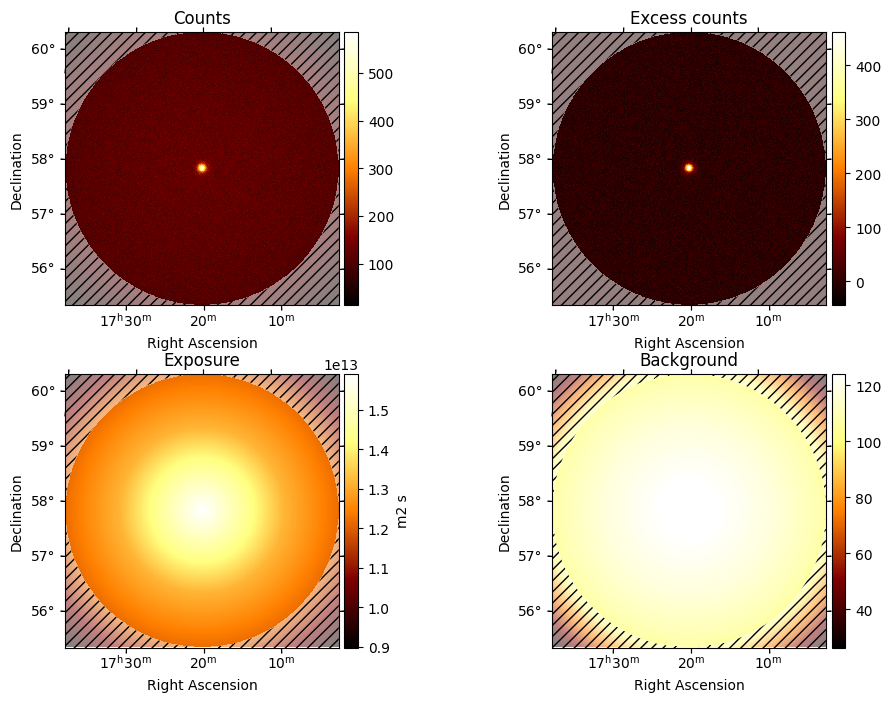

In [116]:
dataset.peek()

In [117]:
#Vamos a duplicar el dataset para tener una nuevo que solo contenga el modelo del fondo para poder realizar el ajuste correctamente
from copy import deepcopy

# Crear una copia profunda del dataset original
dataset_only_bkg = deepcopy(dataset)

# Crear modelo de fondo para este dataset 
bkg_model_only = FoVBackgroundModel(dataset_name=dataset_only_bkg.name)

# Asignar solo el modelo de fondo
dataset_only_bkg.models = Models([bkg_model_only])


In [118]:
print(dataset_only_bkg)

MapDataset
----------

  Name                            : dataset-simu-draco 

  Total counts                    : 22692389 
  Total background counts         : 22612006.80
  Total excess counts             : 80382.20

  Predicted counts                : 22612006.80
  Predicted background counts     : 22612006.80
  Predicted excess counts         : nan

  Exposure min                    : 1.65e+11 m2 s
  Exposure max                    : 2.40e+12 m2 s

  Number of total bins            : 3500000 
  Number of fit bins              : 2749320 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -115492969.65

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : dataset-simu-draco-bkg
    Datasets names            : ['dataset-simu-draco']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm            

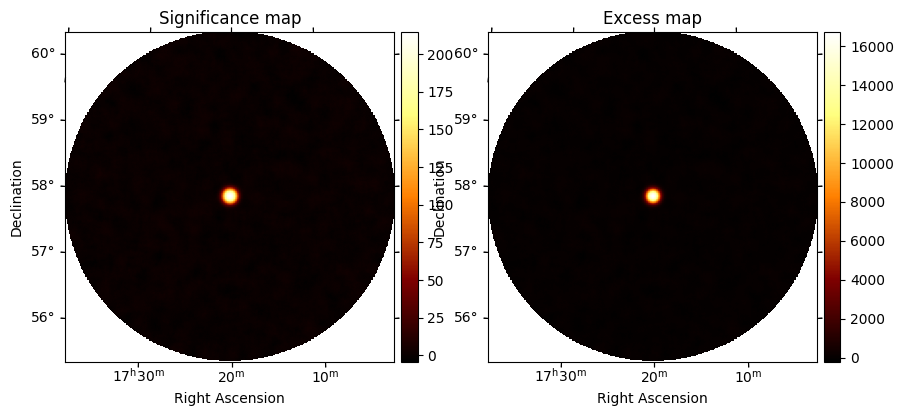

In [119]:
#Mapa de exceso y significancia del dataset que solo tiene el modelo del fondo
from gammapy.estimators import ExcessMapEstimator

estimator = ExcessMapEstimator(
    0.1 * u.deg, selection_optional=[], energy_edges=[0.4, 1] * u.TeV
)

maps = estimator.run(dataset_only_bkg)

plt.figure(figsize=(10, 10))
ax1 = plt.subplot(121, projection=maps.sqrt_ts.geom.wcs)
ax2 = plt.subplot(122, projection=maps.sqrt_ts.geom.wcs)

ax1.set_title("Significance map")
maps.sqrt_ts.plot(ax=ax1, add_cbar=True)

ax2.set_title("Excess map")
maps.npred_excess.plot(ax=ax2, add_cbar=True)
plt.savefig("mapas_significancia.png", dpi=300, bbox_inches="tight")
plt.show()


### Reproducción de curva teórica para la sección de aniquilación en función de la masa de los WIMPS 




In [120]:

def equation_to_solve(x_star, sigma_v, m, g_star):
    m_value = m.value if hasattr(m, 'value') else m

    # Definir el lado derecho de la ecuación
    right_side = 20.5 + np.log(1e26 * sigma_v) + np.log(m_value) - 0.5 * np.log(g_star)
    
    # Definir la ecuación a resolver (convertida en una función numérica)
    return x_star + np.log(x_star - 1.5) - 0.5 * np.log(x_star) - right_side


In [121]:
def calculation_of_xstar(m_CDM, sigma_v, g_star):
    
    solution = []
    for m in m_CDM:
        # Pasar el valor de la masa sin unidades al resolver la ecuación
        x_star_sol = fsolve(equation_to_solve, x0=5, args=(sigma_v, m.to_value(u.GeV), g_star))
        solution.append(x_star_sol[-1])  # Guardar solo la primera solución
            
    return np.array(solution)


In [122]:
m_CDM = np.logspace(-1, 6, 100) * u.GeV  
x_star1 = np.array(calculation_of_xstar(m_CDM, sigma_v.to_value(u.cm**3 / u.s), 106.75))
sigma_v = 3 * 10**(-26) * (u.cm**3 / u.s)

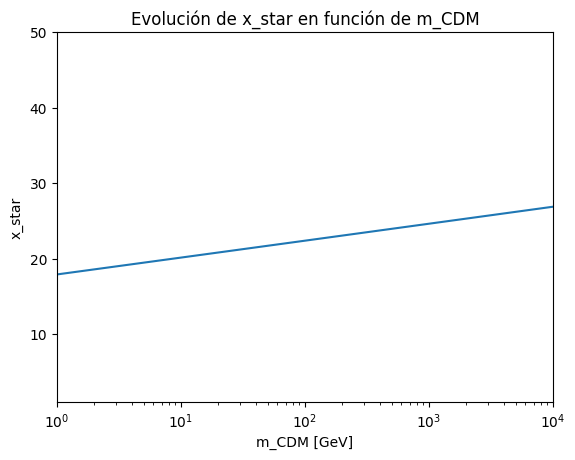

In [123]:

m_CDM_unit = m_CDM.unit if hasattr(m_CDM, 'unit') else 'sin unidades'
plt.plot(m_CDM, x_star1,)
plt.xlabel(f'm_CDM [{m_CDM_unit}]')
plt.xlim([1,10000])
plt.ylim([1,50])
plt.ylabel('x_star')
plt.xscale('log')  
plt.title('Evolución de x_star en función de m_CDM')
plt.show()

In [124]:
# Definimos g(T) y su derivada logarítmica, d(ln g) / d(ln T)
def calculo_g(Temperatura):
    g_value = []
    for T in Temperatura:
        if isinstance(T, (float, int)):  
            T = T * u.GeV  
        if T.value <= 0:
            raise ValueError("La temperatura T debe ser mayor que cero.")
        
        g = (10 
             + 50 / (1 + np.exp(-20 * (np.log10(T.value) + 1)))    # Ajuste para la subida en T = 10^-1 a T = 10^0
             + 25 / (1 + np.exp(-15 * (np.log10(T.value) - 0.5)))  # Ajuste para el escalón en T = 10^0
             + 21.75 / (1 + np.exp(-10 * (np.log10(T.value) - 1.5))) # Ajuste para el escalón en T = 10^1
                )
        g_value.append(g)
    return g_value

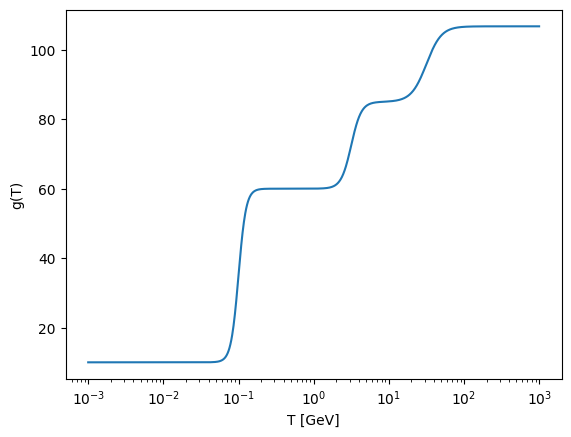

In [125]:
T = np.logspace(-3,3,1000) * u.GeV
g_value=calculo_g(T)
T_unit = T.unit
plt.plot(T, g_value)
plt.xlabel(f'T [{T_unit}]')
plt.ylabel('g(T)')
plt.xscale('log')
plt.show()

In [126]:
def calculation_of_xstar2(m_CDM, sigma_v, g_star_array):
    solution = []
    for i, m in enumerate(m_CDM):
        g_star = g_star_array[i]  
        x_star_sol = fsolve(equation_to_solve, x0=5, args=(sigma_v, m.to_value(u.GeV), g_star))
        solution.append(x_star_sol[-1]) 

    return np.array(solution)


In [127]:
T_star = [m / x for m, x in zip(m_CDM, x_star1)] * u.GeV
g_star_array = np.array(calculo_g(T_star)) 

x_star2 = calculation_of_xstar2(m_CDM, sigma_v.to_value(u.cm**3 / u.s), g_star_array)


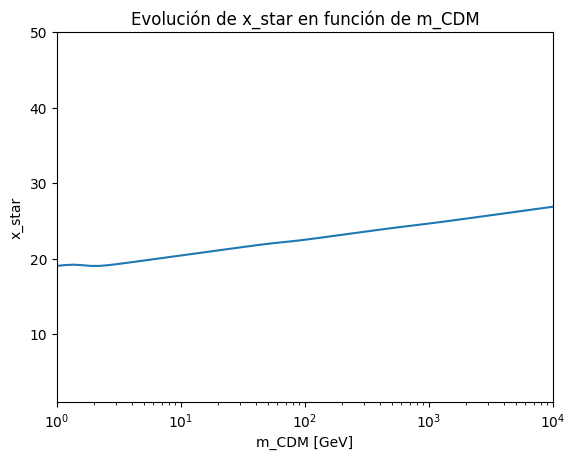

In [128]:
m_CDM_unit = m_CDM.unit if hasattr(m_CDM, 'unit') else 'sin unidades'
plt.plot(m_CDM, x_star2,)
plt.xlabel(f'm_CDM [{m_CDM_unit}]')
plt.xlim([1,10000])
plt.ylim([1,50])
plt.ylabel('x_star')
plt.xscale('log')  # Escala logarítmica en el eje x
plt.title('Evolución de x_star en función de m_CDM')
plt.show()

In [129]:
def calculation_ratioGammaH_star(Delta_star, x_star):
    ratioGammaH_star = [] 
    for x in x_star:
        solucion = (1 + Delta_star) * (x - (3/2))  
        ratioGammaH_star.append(solucion)  
    return ratioGammaH_star


In [130]:
Delta_star_value= 0.618
ratioGammaH_star = np.array(calculation_ratioGammaH_star(Delta_star_value, x_star2))

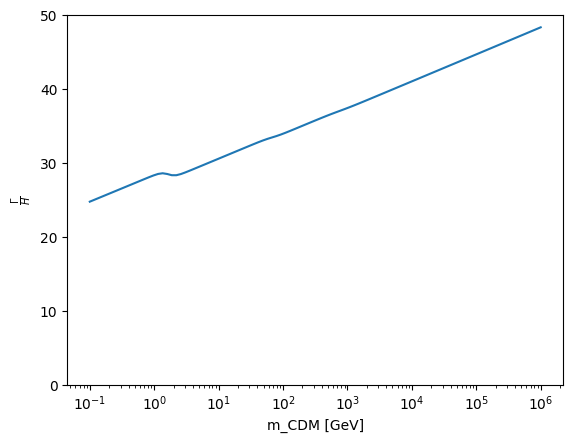

In [131]:
m_CDM_unit = m_CDM.unit if hasattr(m_CDM, 'unit') else 'sin unidades'
plt.plot(m_CDM,ratioGammaH_star)
plt.xscale('log')
plt.ylim([0,50])
plt.xlabel(f'm_CDM [{m_CDM_unit}]')
plt.ylabel(r'$\frac{\Gamma}{H}$')
plt.show()

In [132]:
def d_ln_g_d_ln_T(g_value, T):
    if np.any(T.value <= 0):
        raise ValueError("Todos los valores de T deben ser mayores que cero.")
    else:
        dlng_dlnT = np.gradient(np.log(g_value), np.log(T.value))
        return dlng_dlnT

In [133]:
derivada = d_ln_g_d_ln_T(g_value,T)

In [134]:
#definimos T_star
T_star = [m / x for m, x in zip(m_CDM, x_star2)] * u.GeV

In [135]:
g_star = np.array(calculo_g(T_star))
sqrt_g_star = np.sqrt(g_star)

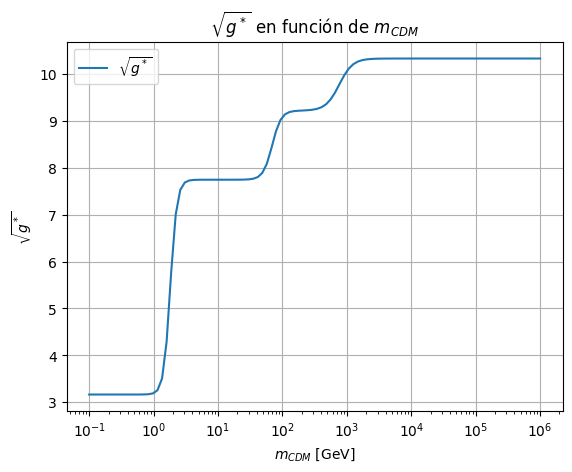

In [136]:
plt.plot(m_CDM, sqrt_g_star, label=r'$\sqrt{g^*}$')
plt.xscale('log')
plt.xlabel(f'$m_{{CDM}}$ [{m_CDM.unit}]')
plt.ylabel(r'$\sqrt{g^*}$')
plt.title(r'$\sqrt{g^*}$ en función de $m_{CDM}$')
plt.grid(True)
plt.legend()
plt.show()

In [153]:
def calculate_alpha_star(T_star, T, g_star_values, derivada):
    alpha_star_values = []
    for T_s, g_star, deriv_star in zip(T_star, g_star_values, derivada):
        T_s_value = T_s.to_value(u.GeV)
        T_f_value = T_s_value / 100

        def integrand(T):
            T_value = T
            g = calculo_g([T_value])[0]
            return (1 / T_s_value) * np.sqrt(g / g_star) * (1 + (1/3) * deriv_star)

        alpha_star, _ = quad(integrand, T_f_value, T_s_value)
        alpha_star_values.append(alpha_star)

    return np.array(alpha_star_values)

In [138]:
alpha_star = calculate_alpha_star(T_star, T, g_star, derivada)
alpha_50 = [a * 50 for a in alpha_star]

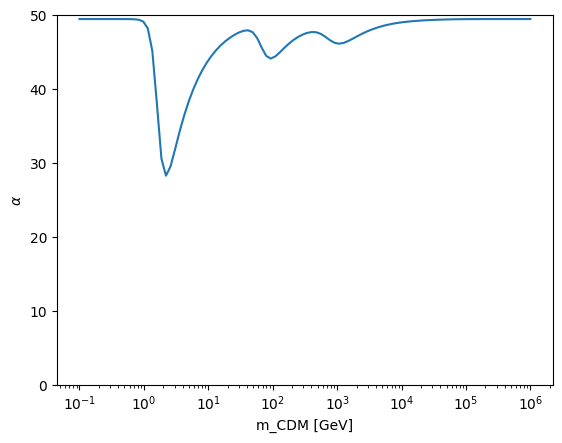

In [139]:
plt.plot(m_CDM,alpha_50)
plt.xlabel(f'm_CDM [{m_CDM.unit}]')
plt.ylabel(r'$\alpha$')
plt.ylim([0,50])
plt.xscale('log')

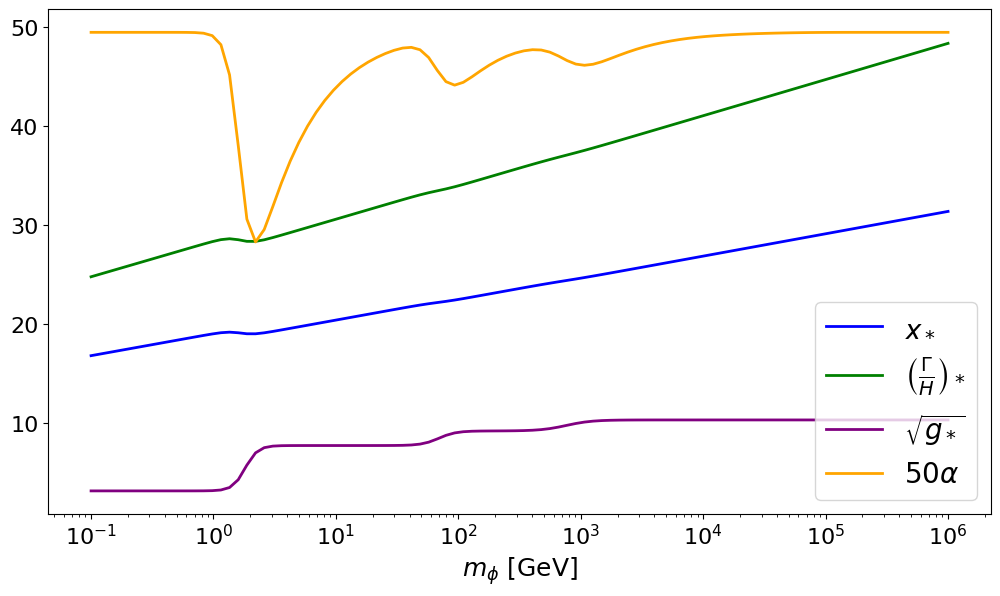

In [140]:
plt.figure(figsize=(10, 6))
# x_star
plt.plot(m_CDM, x_star2, label=r'$x_*$', color='blue', linewidth=2)
# Gamma/H
plt.plot(m_CDM, ratioGammaH_star, label=r'$\left(\frac{\Gamma}{H}\right)_*$', color='green', linewidth=2)
# sqrt(g*)
plt.plot(m_CDM, sqrt_g_star, label=r'$\sqrt{g_*}$', color='purple', linewidth=2)
# alpha
plt.plot(m_CDM, alpha_50, label=r'$50\alpha$', color='orange', linewidth=2)

plt.xscale('log')
plt.xlabel(rf"$m_{{\phi}}$ [{m_CDM.unit}]", fontsize=18)
plt.legend(fontsize=20,loc='lower right')
plt.tight_layout()
plt.tick_params(axis='both', labelsize=16)
plt.savefig('parameters_evolution')
plt.show()


In [141]:
#Vamos a cálcular primero la sección eficaz
def calculation_sigmav(Omegah2, x_star1, g_star, ratioGammaH_star, alpha_star):
    sigmav = []
    for w, x_s, g_s, rGH_s, a_s in zip(Omegah2, x_star1, g_star, ratioGammaH_star, alpha_star):
        s_v = (0.902 * (0.11 / w) * (x_s / (g_s**(1/2))) * (rGH_s / (1 + a_s * rGH_s)))
        sigmav.append(s_v)
    return sigmav

In [142]:
Omegah2 = np.full_like(x_star1, 0.11)
sigmav=np.array(calculation_sigmav(Omegah2, x_star1, g_star, ratioGammaH_star, alpha_star)) 

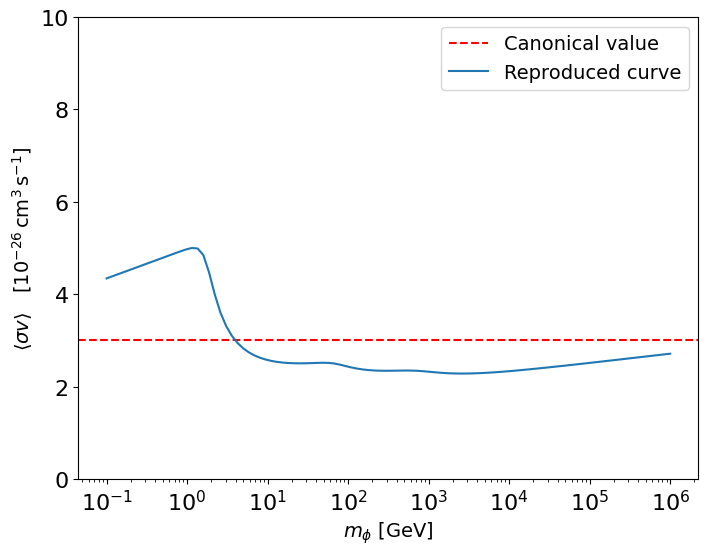

In [143]:
plt.figure(figsize=(8, 6))

canonical_value = 3
plt.axhline(y=canonical_value, color='r', linestyle='--', label='Canonical value')
plt.plot(m_CDM,sigmav, label='Reproduced curve')
plt.xscale('log')
plt.xlabel(rf"$m_{{\phi}}$ [{m_CDM.unit}]", fontsize=14)
plt.ylabel(r'$\langle \sigma v \rangle \quad [ 10^{-26} \, {\rm cm}^{3} \, {\rm s}^{-1} ]$', fontsize=14)
plt.ylim([0,10])
plt.legend(fontsize=14)
plt.tick_params(axis='both', labelsize=16)
plt.savefig('WIMP_relic_abundance.jpg')
plt.show()

In [144]:
# Cargar los datos de los archivos CSV
file_path = r"C:\Users\pauli\Downloads\Default Dataset.csv" 
data = pd.read_csv(file_path, delimiter=';', decimal=',', dtype=np.float64)

# Asignar la primera columna como eje X y la segunda como eje Y
x = np.array(data.iloc[:, 0].values)
y = np.array(data.iloc[:, 1].values)
# Ordenar x y ajustar y en consecuencia
sorted_indices = np.argsort(x)  
x_sorted = x[sorted_indices]    
y_sorted = y[sorted_indices]    


file_path = r"C:\Users\pauli\Downloads\1_sigma_plus.csv" 
data = pd.read_csv(file_path, delimiter=';', decimal=',', dtype=np.float64)

x_1_sigma_plus = np.array(data.iloc[:, 0].values)
y_1_sigma_plus = np.array(data.iloc[:, 1].values)

sorted_indices = np.argsort(x_1_sigma_plus)  
x_1_sigma_plus_sorted = x_1_sigma_plus[sorted_indices]
y_1_sigma_plus_sorted = y_1_sigma_plus[sorted_indices]

file_path = r"C:\Users\pauli\Downloads\1_sigma_minus.csv" 
data = pd.read_csv(file_path, delimiter=';', decimal=',', dtype=np.float64)

x_1_sigma_minus = np.array(data.iloc[:, 0].values)
y_1_sigma_minus = np.array(data.iloc[:, 1].values)

sorted_indices = np.argsort(x_1_sigma_minus) 
x_1_sigma_minus_sorted = x_1_sigma_minus[sorted_indices]
y_1_sigma_minus_sorted = y_1_sigma_minus[sorted_indices]


file_path = r"C:\Users\pauli\Downloads\2_sigma_minus.csv" 
data = pd.read_csv(file_path, delimiter=';', decimal=',', dtype=np.float64)

x_2_sigma_minus = np.array(data.iloc[:, 0].values)
y_2_sigma_minus = np.array(data.iloc[:, 1].values)

sorted_indices = np.argsort(x_2_sigma_minus) 
x_2_sigma_minus_sorted = x_2_sigma_minus[sorted_indices]
y_2_sigma_minus_sorted = y_2_sigma_minus[sorted_indices]


file_path = r"C:\Users\pauli\Downloads\2_sigma_plus.csv" 
data = pd.read_csv(file_path, delimiter=';', decimal=',', dtype=np.float64)

x_2_sigma_plus = np.array(data.iloc[:, 0].values)
y_2_sigma_plus = np.array(data.iloc[:, 1].values)

sorted_indices = np.argsort(x_1_sigma_plus)  
x_2_sigma_plus_sorted = x_1_sigma_plus[sorted_indices]
y_2_sigma_plus_sorted = y_1_sigma_plus[sorted_indices]

file_path = r"C:\Users\pauli\Downloads\5 sigma.csv" 
data = pd.read_csv(file_path, delimiter=';', decimal=',', dtype=np.float64)

x_5_sigma = np.array(data.iloc[:, 0].values)
y_5_sigma = np.array(data.iloc[:, 1].values)

sorted_indices = np.argsort(x_5_sigma)  
x_5_sigma_sorted = x_5_sigma[sorted_indices]
y_5_sigma_sorted = y_5_sigma[sorted_indices]

file_path = r"C:\Users\pauli\Downloads\Fermi_LAT.csv" 
data = pd.read_csv(file_path, delimiter=';', decimal=',', dtype=np.float64)

x_FERMI = np.array(data.iloc[:, 0].values)
y_FERMI = np.array(data.iloc[:, 1].values)

sorted_indices = np.argsort(x_FERMI)  
x_FERMI_sorted = x_FERMI[sorted_indices]
y_FERMI_sorted = y_FERMI[sorted_indices]

file_path = r"C:\Users\pauli\Downloads\MAGIC.csv" 
data = pd.read_csv(file_path, delimiter=';', decimal=',', dtype=np.float64)

x_MAGIC = np.array(data.iloc[:, 0].values)
y_MAGIC = np.array(data.iloc[:, 1].values)

sorted_indices = np.argsort(x_MAGIC)  
x_MAGIC_sorted = x_MAGIC[sorted_indices]
y_MAGIC_sorted = y_MAGIC[sorted_indices]

file_path = r"C:\Users\pauli\Downloads\HESS.csv" 
data = pd.read_csv(file_path, delimiter=';', decimal=',', dtype=np.float64)

x_HESS = np.array(data.iloc[:, 0].values)
y_HESS = np.array(data.iloc[:, 1].values)

sorted_indices = np.argsort(x_HESS)  
x_HESS_sorted = x_HESS[sorted_indices]
y_HESS_sorted = y_HESS[sorted_indices]




In [145]:
# Genera la tabla
data = {'X': x_sorted, 'Y': y_sorted}
df = pd.DataFrame(data)

dataFERMI = {'X': x_FERMI_sorted, 'Y': y_FERMI_sorted}
dfFERMI = pd.DataFrame(dataFERMI)

dataMAGIC = {'X': x_MAGIC_sorted, 'Y': y_MAGIC_sorted}
dfMAGIC = pd.DataFrame(dataMAGIC)

dataHESS = {'X': x_HESS_sorted, 'Y': y_HESS_sorted}
dfHESS = pd.DataFrame(dataHESS)

In [146]:
#definimos una función para cálcular la sección eficaz del paper que queremos en concreto
def calculo_sigma_v_nueva(theta_W, Lambda_B, m_CDM_nueva):
    sigma_v_nueva = []
    
    for k in Lambda_B:
        sigma_v_lambda = []  
       
        for l in m_CDM_nueva:
            s_v_nueva = (2 * l**2 / np.pi) * (
                    (np.cos(theta_W) / k)**4 + 
                    (2 * (np.cos(theta_W))**2 * (np.sin(theta_W))**2) / ((k * k)**2) + 
                    (np.sin(theta_W) / k)**4
                )*(1.3*10**(-18))
            sigma_v_lambda.append(s_v_nueva)  
        sigma_v_nueva.append(sigma_v_lambda)  
    return np.array(sigma_v_nueva)  

In [147]:
#Calculamos valores para sigma_v
m_CDM_nueva = np.logspace(-1, 2, 100)  # in TeV
Lambda = np.logspace(1, 4, 20)       # coupling constant
theta_W = 0.49 * u.rad  # electroweak mixing angle in radians
sigma_v_nueva1 = calculo_sigma_v_nueva(theta_W, Lambda, m_CDM_nueva) 

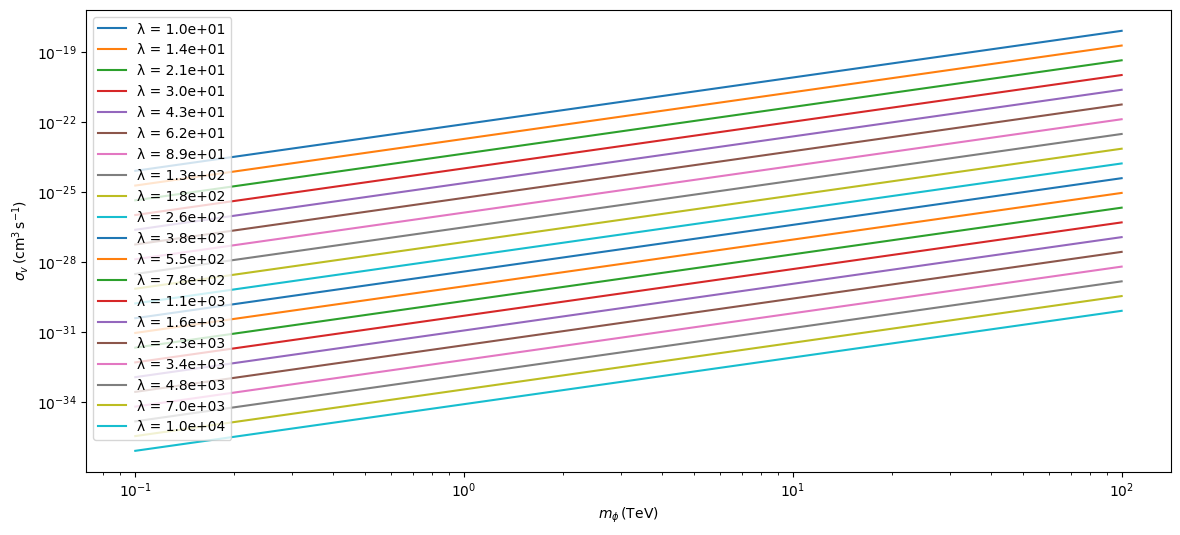

In [148]:
# Crear figura con dos subplots en una fila
plt.figure(figsize=(14, 6))
for i, lambda_val in enumerate(Lambda):
    plt.plot(m_CDM_nueva, sigma_v_nueva1[i], label=f'λ = {lambda_val:.1e}')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$m_{\phi} \, (\mathrm{TeV})$')
plt.ylabel(r'$\sigma_v \, (\mathrm{cm}^3 \, \mathrm{s}^{-1})$')
plt.legend()

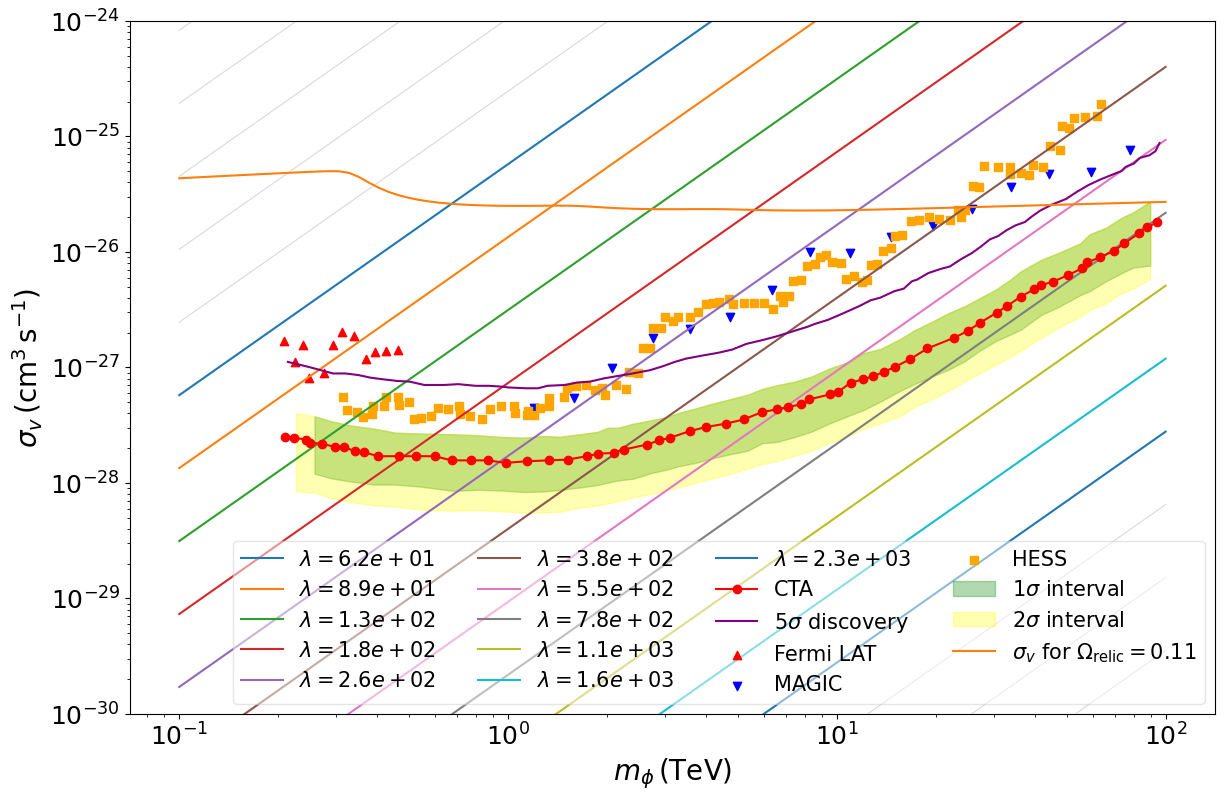

In [149]:
plt.figure(figsize=(14, 9))


plt.yscale('log')
plt.xscale('log')
plt.ylim(1e-30, 1e-24)

# Curvas de λ, con control de visibilidad en el eje Y
for i, lambda_val in enumerate(Lambda):
    y_vals = sigma_v_nueva1[i]
    if np.any((np.array(y_vals) >= 1e-28) & (np.array(y_vals) <= 1e-27)):
        plt.plot(m_CDM_nueva, y_vals, label=fr'$\lambda = {lambda_val:.1e}$')
    else:
        plt.plot(m_CDM_nueva, y_vals, alpha=0.3, linewidth=0.8, color='gray')


plt.xlabel(r'$m_{\phi} \, (\mathrm{TeV})$', fontsize=20)
plt.ylabel(r'$\sigma_v \, (\mathrm{cm}^3 \, \mathrm{s}^{-1})$', fontsize=20)
#plt.title(r'$\sigma_v$ vs $m_{\mathrm{CDM}}$ for different $\lambda$ values')

# Curvas observacionales
plt.plot(x_sorted, y_sorted, 'o-', color='red', label=r'CTA') 
plt.plot(x_5_sigma_sorted, y_5_sigma_sorted, '-', color='purple', label=r'$5\sigma$ discovery')
plt.scatter(x_FERMI_sorted, y_FERMI_sorted, color='red', label=r'Fermi LAT', marker='^')  
plt.scatter(x_MAGIC_sorted, y_MAGIC_sorted, color='blue', label=r'MAGIC', marker='v')
plt.scatter(x_HESS_sorted, y_HESS_sorted, color='orange', label=r'HESS', marker='s')

# Banda 1σ
x_min = max(min(x_1_sigma_plus_sorted), min(x_1_sigma_minus_sorted))
x_max = min(max(x_1_sigma_plus_sorted), max(x_1_sigma_minus_sorted))
mask_plus = (x_1_sigma_plus_sorted >= x_min) & (x_1_sigma_plus_sorted <= x_max)
mask_minus = (x_1_sigma_minus_sorted >= x_min) & (x_1_sigma_minus_sorted <= x_max)
x_1_sigma_plus_filtered = x_1_sigma_plus_sorted[mask_plus]
y_1_sigma_plus_filtered = y_1_sigma_plus_sorted[mask_plus]
x_1_sigma_minus_filtered = x_1_sigma_minus_sorted[mask_minus]
y_1_sigma_minus_filtered = y_1_sigma_minus_sorted[mask_minus]
y_1_sigma_minus_interpolated = np.interp(x_1_sigma_plus_filtered, x_1_sigma_minus_filtered, y_1_sigma_minus_filtered)
plt.fill_between(x_1_sigma_plus_filtered, y_1_sigma_plus_filtered, y_1_sigma_minus_interpolated, color='green', alpha=0.3, label=r'$1\sigma$ interval')

# Banda 2σ
x_min = max(min(x_2_sigma_plus_sorted), min(x_2_sigma_minus_sorted))
x_max = min(max(x_2_sigma_plus_sorted), max(x_2_sigma_minus_sorted))
mask_plus = (x_2_sigma_plus_sorted >= x_min) & (x_2_sigma_plus_sorted <= x_max)
mask_minus = (x_2_sigma_minus_sorted >= x_min) & (x_2_sigma_minus_sorted <= x_max)
x_2_sigma_plus_filtered = x_2_sigma_plus_sorted[mask_plus]
y_2_sigma_plus_filtered = y_2_sigma_plus_sorted[mask_plus]
x_2_sigma_minus_filtered = x_2_sigma_minus_sorted[mask_minus]
y_2_sigma_minus_filtered = y_2_sigma_minus_sorted[mask_minus]
y_2_sigma_minus_interpolated = np.interp(x_2_sigma_plus_filtered, x_2_sigma_minus_filtered, y_2_sigma_minus_filtered)
plt.fill_between(x_2_sigma_plus_filtered, y_2_sigma_plus_filtered, y_2_sigma_minus_interpolated, color='yellow', alpha=0.3, label=r'$2\sigma$ interval')

# Curva de densidad reliquia
sigmavreliquia = [x * 10**(-26) for x in sigmav]
plt.plot(m_CDM_nueva, sigmavreliquia, label=r'$\sigma_v$ for $\Omega_{\mathrm{relic}} = 0.11$')

plt.legend(loc='lower right', 
           bbox_to_anchor=(1.0, 0.0), 
           ncol=4, 
           fontsize=15, framealpha=0.5)
plt.tick_params(axis='both', labelsize=18)
plt.savefig("sigma_v_constrains")
plt.show()


In [150]:
data = {'X': m_CDM_nueva, 'Y': sigmavreliquia}
dfpaper = pd.DataFrame(data)

In [151]:
# Interpolación para igualar valores de X
x_common = np.linspace(max(dfpaper['X'].min(), df['X'].min()), min(dfpaper['X'].max(), df['X'].max()), 100)

# Interpola los valores de Y para ambos DataFrames
y1_interpolated = np.interp(x_common, dfpaper['X'], dfpaper['Y'])
y2_interpolated = np.interp(x_common, df['X'], df['Y'])

y_difference = y2_interpolated/y1_interpolated

result_df = pd.DataFrame({'X': x_common, 'Y Difference': y_difference})

x_commonFERMI = np.linspace(max(dfpaper['X'].min(), dfFERMI['X'].min()), min(dfpaper['X'].max(), dfFERMI['X'].max()), 100)

y1_interpolated = np.interp(x_common, dfpaper['X'], dfpaper['Y'])
y2_interpolated = np.interp(x_common, dfFERMI['X'], dfFERMI['Y'])


y_differenceFERMI = y2_interpolated/y1_interpolated


result_df = pd.DataFrame({'X': x_commonFERMI, 'Y Difference': y_differenceFERMI})

x_commonMAGIC = np.linspace(max(dfpaper['X'].min(), dfMAGIC['X'].min()), min(dfpaper['X'].max(), dfMAGIC['X'].max()), 100)

y1_interpolated = np.interp(x_common, dfpaper['X'], dfpaper['Y'])
y2_interpolated = np.interp(x_common, dfMAGIC['X'], dfMAGIC['Y'])

y_differenceMAGIC = y2_interpolated/y1_interpolated

result_df = pd.DataFrame({'X': x_commonMAGIC, 'Y Difference': y_differenceMAGIC})

x_commonHESS = np.linspace(max(dfpaper['X'].min(), dfHESS['X'].min()), min(dfpaper['X'].max(), dfHESS['X'].max()), 100)

y1_interpolated = np.interp(x_common, dfpaper['X'], dfpaper['Y'])
y2_interpolated = np.interp(x_common, dfHESS['X'], dfHESS['Y'])

y_differenceHESS = y2_interpolated/y1_interpolated

result_df = pd.DataFrame({'X': x_commonHESS, 'Y Difference': y_differenceHESS})

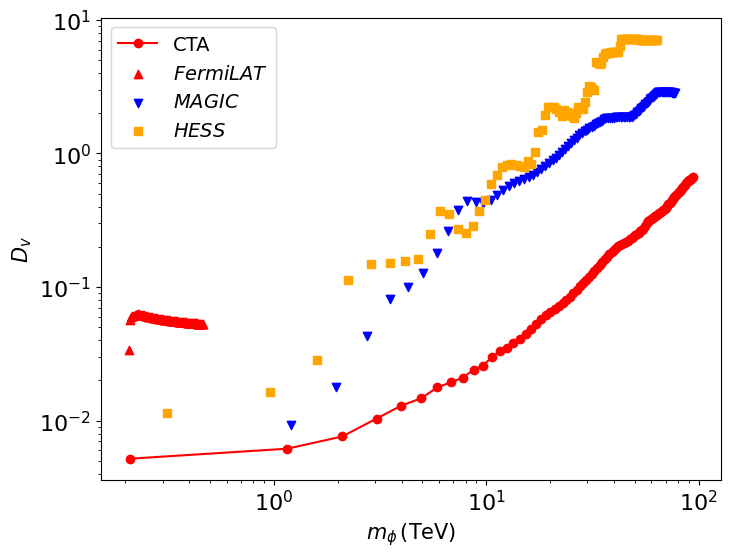

In [152]:
plt.figure(figsize=(8, 6))
plt.xscale('log')
plt.yscale('log')
plt.plot(x_common,y_difference, 'o-', color='red', label='CTA')
plt.scatter(x_commonFERMI, y_differenceFERMI, color='red', label='$Fermi LAT$', marker='^') 
plt.scatter(x_commonMAGIC, y_differenceMAGIC, color='blue', label='$MAGIC$', marker='v')
plt.scatter(x_commonHESS, y_differenceHESS, color='orange', label='$HESS$', marker='s')
plt.xlabel(r'$m_{\phi} \, (\mathrm{TeV})$', fontsize=15)
plt.ylabel(r'$D_v$', fontsize=15)
plt.legend(fontsize=14)
plt.tick_params(axis='both', labelsize=16)
plt.savefig('delusional_factor')
plt.show()